In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from scipy.io import loadmat
from sklearn.model_selection import StratifiedKFold
from keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Model
from scipy.optimize import minimize
from keras import regularizers
import scipy
import math
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import mahalanobis
from sklearn.model_selection import ParameterGrid


In [5]:
dataTT = loadmat(f"Data04-08_TT_UltVag_Cut.mat")
dataTF = loadmat(f"Data04-08_TF_UltVag_Cut.mat")

dataBaseline = dataTF['Baseline']
dataCincoP = dataTF['CincoP']
dataDez = dataTF['DezP']
dataVinte = dataTF['VinteP']

dataBaseline = pd.DataFrame(dataBaseline)
x_test_Baseline = dataBaseline.sample(200, random_state = 42)
dataBaseline_train = dataBaseline.drop(x_test_Baseline.index)

dataCincoP = pd.DataFrame(dataCincoP)

dataDez = pd.DataFrame(dataDez)

dataVinte = pd.DataFrame(dataVinte)


In [6]:
def run_autoencoder(dataBaseline_train, x_test_Baseline, epochs, patience, batch_size):
    num_terms = dataBaseline_train.columns.shape[0]
    input_layer = Input(shape=(num_terms,))
    encoded = layers.Dense(64, activation='relu')(input_layer)
    encoded = layers.Dense(32, activation='relu')(encoded)
    encoded = layers.Dense(16, activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoded)
    
    decoded = layers.Dense(16, activation='relu')(encoded)
    decoded = layers.Dense(32, activation='relu')(decoded)
    decoded = layers.Dense(64, activation='relu')(decoded)
    decoded = layers.Dense(num_terms, activation='linear')(decoded)

    autoencoder = keras.Model(input_layer, decoded)

    autoencoder.compile(optimizer='adam', loss='mae')

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience) 

    autoencoder.fit(dataBaseline_train, dataBaseline_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    callbacks=[callback],
                    validation_data=(x_test_Baseline, x_test_Baseline),
                    verbose=0)
    
    return autoencoder

def optimize_hyperparameters(dataBaseline_train, x_test_Baseline, num_runs=5):
    # Define a grade de parâmetros a serem testados
    param_grid = {
        'epochs': [500, 1000, 1500],
        'patience': [100, 200, 300],
        'batch_size': [20, 40, 60]
    }
    
    best_loss = float('inf')
    best_params = None

    # Realiza a busca em grade com validação cruzada
    for params in ParameterGrid(param_grid):
        total_loss = 0.0
        for _ in range(num_runs):
            autoencoder = run_autoencoder(dataBaseline_train, x_test_Baseline, **params)
            total_loss += autoencoder.history.history['loss'][-1] # Apenas a perda final

        avg_loss = total_loss / num_runs

        # Atualiza os melhores parâmetros, se necessário
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_params = params

    return best_params, best_loss

best_params, best_loss = optimize_hyperparameters(dataBaseline_train, x_test_Baseline)

print("Melhores Hiperparâmetros:")
print(best_params)
print("Menor Loss Médio Encontrado:", best_loss)

Melhores Hiperparâmetros:
{'batch_size': 40, 'epochs': 1500, 'patience': 100}
Menor Loss Médio Encontrado: 0.006076144520193338


In [7]:
def plotagem_reconstrução(df_analisado):
    
    autoencoder = run_autoencoder(dataBaseline, x_test_Baseline)
    n = 1
    x = np.arange(0, 5830)
    decoded_results = autoencoder.predict(df_analisado)
    plt.figure(figsize=(20, 15))

    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.plot(x, df_analisado.iloc[i].values, label="Original")

        # Display reconstruction
        plt.plot(x, decoded_results[i], label="Reconstruction")

    plt.legend()
    plt.show()

#plotagem_reconstrução(dataCincoP)

In [8]:
def mahalanobis_cenario(dado_analisado, dataBaseline):

    num_conjuntos = 10 # 20 conjuntos de 40 termos. Ou seja: 800 dados
    num_dados = 80
    rodagens_autoencoder = 5
    Mahalanobis_distancias = []

    for i in range(rodagens_autoencoder):

        autoencoder = run_autoencoder(dataBaseline, x_test_Baseline)

        for conjunto in range(num_conjuntos):
            
            mae_Baseline = np.array([])
            mae_Medio = np.array([]) 
            
            dados_baseline_atual = pd.DataFrame(dataBaseline).sample(num_dados)
            dado_analisado_atual = pd.DataFrame(dado_analisado).sample(num_dados)

            for dado_atual in range(num_dados):
                
                # Cálculo do MAE para o conjunto de dados baseline
                y = np.array(dados_baseline_atual.iloc[dado_atual])
                y_predict = autoencoder.predict(dados_baseline_atual.iloc[dado_atual].values.reshape(1, -1), verbose=0)
                y_predict = y_predict[0]
                mae_Atual = np.mean(np.abs((y_predict - y)))  
                mae_Baseline = np.append(mae_Baseline, mae_Atual)

            for dado_atual in range(num_dados):
                # Cálculo do MAE para o conjunto de dados a ser analisado
                y = np.array(dado_analisado_atual.iloc[dado_atual])
                y_predict = autoencoder.predict(dado_analisado_atual.iloc[dado_atual].values.reshape(1, -1), verbose=0)
                y_predict = y_predict[0]
                mae_Atual = np.mean(np.abs((y_predict - y)))  
                mae_Medio = np.append(mae_Medio, mae_Atual)

            
            epsilon = 0.01 # Valor de regularização
            # Calculando a distância de Mahalanobis 
            V = np.cov(np.array([mae_Medio, mae_Baseline]).T) # Matriz de covariância
            V += epsilon * np.eye(V.shape[0]) # Adicionando ruído diagonal
            IV = np.linalg.inv(V) # Inversa da matriz de covariância

            mahalanobis_distance = mahalanobis(mae_Medio, mae_Baseline, IV) # Distância de Mahalanobis

            Mahalanobis_distancias.append(mahalanobis_distance)

            #Mahalanobis_distancias = [valor for valor in Mahalanobis_distancias if not pd.isna(valor)]

            print(F"Distância de Mahalanobis da iteração {i}:", Mahalanobis_distancias)
    
    return Mahalanobis_distancias

# Chamar a função mahalanobis

#MahalanobisBaseline = mahalanobis_cenario(dado_analisado = dataBaseline, dataBaseline = dataBaseline)

MahalanobisCinco = mahalanobis_cenario(dado_analisado = dataCincoP, dataBaseline = dataBaseline)

MahalanobisDez = mahalanobis_cenario(dado_analisado = dataDez, dataBaseline = dataBaseline)

MahalanobisVinte = mahalanobis_cenario(dado_analisado = dataVinte, dataBaseline = dataBaseline)

TypeError: run_autoencoder() missing 3 required positional arguments: 'epochs', 'patience', and 'batch_size'

In [9]:
x = np.arange(0, MahalanobisCinco.__len__())

#Média distâncias
#print(np.array(MahalanobisBaseline).mean())
print(np.array(MahalanobisCinco).mean())
print(np.array(MahalanobisDez).mean())
print(np.array(MahalanobisVinte).mean())

# Plotagens
#plt.plot(x, MahalanobisBaseline, label='Mahalanobis Baseline')
plt.plot(x, MahalanobisCinco, label='Mahalanobis Cinco')
plt.plot(x, MahalanobisDez, label='Mahalanobis Dez')
plt.plot(x, MahalanobisVinte, label='Mahalanobis Vinte')

# Legendas
plt.legend()

# Título e rótulos dos eixos
plt.title('Comparação das distâncias de Mahalanobis')
plt.xlabel('Índice do conjunto analisado')
plt.ylabel('Distância')

# Adiciona grade
plt.grid(True)

# Ajustes estéticos opcionais
plt.style.use('seaborn-darkgrid')  # Estilo do gráfico
plt.tight_layout()  # Ajusta o layout para evitar cortes

# Exibição do gráfico
plt.show()


NameError: name 'MahalanobisCinco' is not defined

In [ ]:
def data_split(data, p=0.1):
    if np.isscalar(p) and p >= 1.0:
        return data
    
    n_data = data.shape[0]
    idx = np.arange(n_data)
    np.random.shuffle(idx)
    
    idx = idx[:int(n_data * p)]
    return data.iloc[idx, :]

In [ ]:
Teste_Caso = ["x_test_Baseline_splitted", "x_test_Cinco_splitted", "x_test_Dez_splitted", "x_test_Vinte_splitted"]
legenda = ['Baseline', 'DC1=5%', 'DC2=10%', 'DC3=20%'] 
cor = ['forestgreen', 'orange', 'royalblue', 'firebrick', 'magenta']

In [ ]:
ntestes = 4 # Quantas variáveis de dano são adicionadas
n_it = 40 #Numero de conjuntos
n_vbatch = 5 #Numero de rodadas do AE - variabilidade do processador
n_passagens = 50  #Numero de passagens para cada ponto da curva ROC/cada conjunto
n_passag = '50'

n_pass_base = n_passagens/800
n_pass_dano = n_passagens/1000
    
Media = np.zeros((ntestes, n_it, n_vbatch))
Desvio = np.zeros((ntestes, n_it, n_vbatch))
Mediana = np.zeros((ntestes, n_it, n_vbatch))
DKL = np.zeros((ntestes, n_it, n_vbatch))
DI = np.zeros((ntestes, n_it, n_vbatch))

for n in range(n_vbatch):  
        
        autoencoder = run_autoencoder(dataBaseline, x_test_Baseline)

        reconstructions_train = autoencoder.predict(dataBaseline)
        train_loss = tf.keras.losses.mae(reconstructions_train, dataBaseline)

        #Ajuste de uma distribuição normal para Y=ln(train_loss)
        train_norm_log = np.log(train_loss)
        normFittolog_train = scipy.stats.norm.fit(train_norm_log)
        
        MediaTrain = normFittolog_train[0]
        DesvioTrain = normFittolog_train[1]

        min_val = tf.reduce_min(dataBaseline)
        max_val = tf.reduce_max(dataBaseline)

        for iter in range(n_it):
          print('Iteração: ', iter)
          for t in range(ntestes):

            x_test_Baseline_splitted = data_split(x_test_Baseline, p=n_pass_base)
            x_test_Cinco_splitted = data_split(x_test_Cinco, p=n_pass_dano)
            x_test_Dez_splitted = data_split(x_test_Dez, p=n_pass_dano)
            x_test_Vinte_splitted = data_split(x_test_Vinte, p=n_pass_dano)


            Teste = eval(Teste_Caso[t])
            Teste = Teste.values
            teste_data = (Teste - min_val) / (max_val - min_val)
            teste_data = tf.cast(teste_data, tf.float32)
          
            #Crie um gráfico semelhante, desta vez para o teste com dano
            reconstructions = autoencoder.predict(teste_data)
            test_loss = tf.keras.losses.mae(reconstructions, teste_data)
            
            test_norm_log = np.log(test_loss)
            normFittolog_test = scipy.stats.norm.fit(test_norm_log)
            
            
            #Media[t, iter, n] = MediaTestNC/fc   #Media do teste corrigido pelo fc
            Media[t, iter, n] = normFittolog_test[0]
            Desvio[t, iter, n] = normFittolog_test[1]
            Mediana[t, iter, n] = np.median(test_loss)
            
            DKL[t, iter, n] = np.log(Desvio[t, iter, n]/DesvioTrain)+((1/(2*(Desvio[t, iter, n]**2)))*((DesvioTrain**2)+(Media[t, iter, n]-MediaTrain)**2))-(1/2)      
            DI[t, iter, n] = np.log(DKL[t, iter, n]+math.exp(1))-1

32/32 [==============================] - 0s 2ms/step
Iteração:  0
1/1 [==============================] - 0s 9ms/step
Iteração:  1
1/1 [==============================] - 0s 10ms/step
Iteração:  2
1/1 [==============================] - 0s 10ms/step
Iteração:  3
1/1 [==============================] - 0s 10ms/step
Iteração:  4
1/1 [==============================] - 0s 10ms/step
Iteração:  5
1/1 [==============================] - 0s 10ms/step
Iteração:  6
1/1 [==============================] - 0s 9ms/step
Iteração:  7
1/1 [==============================] - 0s 15ms/step
Iteração:  8
1/1 [==============================] - 0s 10ms/step
Iteração:  9
1/1 [==============================] - 0s 9ms/step
Iteração:  10
1/1 [==============================] - 0s 10ms/step
Iteração:  11
1/1 [==============================] - 0s 10ms/step
Iteração:  12
1/1 [==============================] - 0s 10ms/step
Iteração:  13
1/1 [==============================] - 0s 10ms/step
Iteração:  14
1/1 [=================

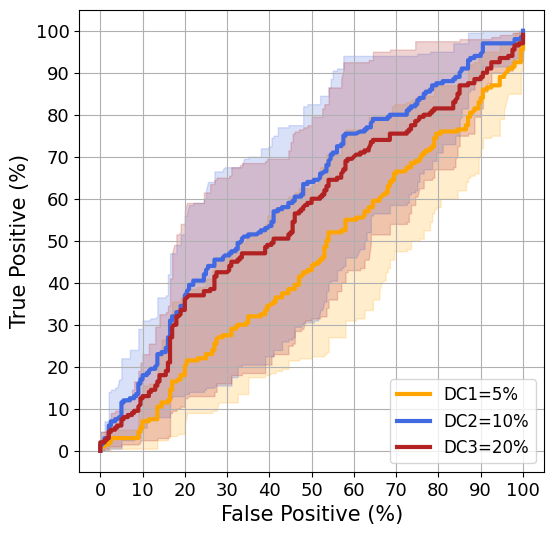

In [ ]:
## ROC based KLD
# Calculate (P || q)
n_thresholds = 5000

metrica = DI  # Media, Desvio, Mediana ou DI
metric = 'DKL'

verdadeiros_negativos = np.zeros((3, n_thresholds, n_vbatch))  # 5%, 10%, and 20%
verdadeiros_positivos = np.zeros((3, n_thresholds, n_vbatch))
falsos_negativos = np.zeros((3, n_thresholds, n_vbatch))
falsos_positivos = np.zeros((3, n_thresholds, n_vbatch))

tpr = np.zeros((3, n_thresholds, n_vbatch))
fpr = np.zeros((3, n_thresholds, n_vbatch))

# Plots

for nvar in range(n_vbatch):
    sem_dano = metrica[0, :, nvar]

    min_threshold = metrica[:, :, nvar].min()
    max_threshold = metrica[:, :, nvar].max()

    for caso in range(metrica.shape[0] - 1):  # Cenarios de 5%, 10% e 20%
        com_dano = metrica[caso + 1, :, nvar]

        thresholds = np.linspace(min_threshold, max_threshold, n_thresholds)
        for idx, threshold in enumerate(thresholds):
            verdadeiros_negativos[caso, idx, nvar] = np.sum(sem_dano <= threshold)
            verdadeiros_positivos[caso, idx, nvar] = np.sum(com_dano > threshold)
            falsos_negativos[caso, idx, nvar] = np.sum(com_dano <= threshold)
            falsos_positivos[caso, idx, nvar] = np.sum(sem_dano > threshold)

            tpr[caso, idx, nvar] = verdadeiros_positivos[caso, idx, nvar] / (
            verdadeiros_positivos[caso, idx, nvar] + falsos_negativos[caso, idx, nvar])
            fpr[caso, idx, nvar] = falsos_positivos[caso, idx, nvar] / (
            falsos_positivos[caso, idx, nvar] + verdadeiros_negativos[caso, idx, nvar])

tprMean = np.zeros((3, n_thresholds))
fprMean = np.zeros((3, n_thresholds))

fig, ax2 = plt.subplots()

# Obtem a media e desvio das taxas de VPs e FPs para cada cenario e threshold
for caso in range(metrica.shape[0] - 1):
    for idx in range(n_thresholds):
        # tpr e fpr
        tprMean[caso, idx] = np.mean(tpr[caso, idx, :])
        fprMean[caso, idx] = np.mean(fpr[caso, idx, :])

    # Calcula os percentis 2.5 e 97.5 para criar a faixa de confiança
    percentile_2_5 = np.percentile(tpr[caso, :, :], 5, axis=1) * 100
    percentile_97_5 = np.percentile(tpr[caso, :, :], 95, axis=1) * 100

    ax2.plot(fprMean[caso, :] * 100, tprMean[caso, :] * 100, linewidth=3.0, color=cor[caso + 1],
             label=f'{legenda[caso + 1]}')
    ax2.fill_between(fprMean[caso, :] * 100, percentile_2_5, percentile_97_5, color=cor[caso + 1], alpha=0.2)

ax2.legend(loc='lower right', numpoints=1, fontsize=12)
plt.xlabel('False Positive (%)', fontsize=15)
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], fontsize=13)
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], fontsize=13)
plt.ylabel('True Positive (%)', fontsize=15)
plt.grid(True)
fig.set_size_inches(6, 6)
plt.show()


1/1 [==============================] - 0s 10ms/step


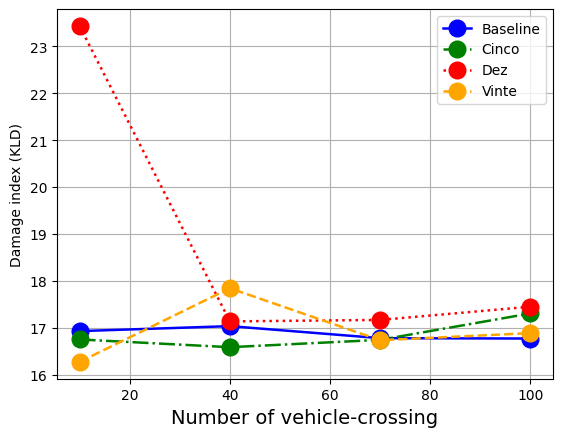

In [ ]:
def plot_KLD(ncenarios):
    Caso = ["x_test_Baseline_splitted", "x_test_Cinco_splitted", "x_test_Dez_splitted", "x_test_Vinte_splitted"]

    n_teste = 0.2  # Treinado com 100 dados de aceleração do baseline (testado 80%)

    # Divide os dados baseline em dois conjuntos - para treinamento e validacao
    baseline_train, baseline_valid = train_test_split(
        dataBaseline_train, test_size=n_teste, random_state=42
    )

    linha = ['solid', 'dashdot', 'dotted', 'dashed']

    n_it = 1  # Numero de amostras

    n_vbatch = 4  # Conjuntos de passagens de veículos analisados (50 a 400 de 50 em 50)

    n_pass_base = np.linspace((0.01 / n_teste), (0.1 / n_teste), num=n_vbatch)
    n_pass_dano = np.linspace(0.01, 0.1, num=n_vbatch)

    Teste = np.zeros((ncenarios, x_test_Baseline.shape[0], x_test_Baseline.shape[1], n_it, n_vbatch))
    Media = np.zeros((ncenarios, n_it, n_vbatch))
    Desvio = np.zeros((ncenarios, n_it, n_vbatch))

    MediaTrain = np.zeros((n_it))
    DesvioTrain = np.zeros((n_it))
    MedianaTrain = np.zeros((n_it))

    autoencoder = run_autoencoder(baseline_train, baseline_valid)

    min_val = tf.reduce_min(baseline_train)
    max_val = tf.reduce_max(baseline_train)

    for n in range(n_vbatch):
        p_base = n_pass_base[n]
        p_dano = n_pass_dano[n]

        for iter in range(n_it):
            reconstructions_train = autoencoder.predict(baseline_train)
            train_loss = tf.keras.losses.mae(reconstructions_train, baseline_train)

            train_norm_log = np.log(train_loss)
            normFittolog_train = scipy.stats.norm.fit(train_norm_log)

            MediaTrain[iter] = normFittolog_train[0]
            DesvioTrain[iter] = normFittolog_train[1]

            for t in range(ncenarios):
                x_test_Baseline_splitted = data_split(x_test_Baseline, p=p_base).values
                x_test_Cinco_splitted = data_split(x_test_Cinco, p=p_dano).values
                x_test_Dez_splitted = data_split(x_test_Dez, p=p_dano).values
                x_test_Vinte_splitted = data_split(x_test_Vinte, p=p_dano).values

                Teste_atual = eval(Caso[t])

                teste_data = (Teste_atual - min_val) / (max_val - min_val)
                teste_data = tf.cast(teste_data, tf.float32)

                reconstructions = autoencoder.predict(teste_data)
                test_loss = tf.keras.losses.mae(reconstructions, teste_data)

                test_norm_log = np.log(test_loss)
                normFittolog_test = scipy.stats.norm.fit(test_norm_log)

                Media[t, iter, n] = normFittolog_test[0]
                Desvio[t, iter, n] = normFittolog_test[1]

    n_vbatch = len(Media[0, 0, :])  # Numero de conjunto de passagens analizadas
    ncenarios = len(Media[:, 0, 0])  # Numero de cenarios analisados

    DI = np.zeros((ncenarios, n_vbatch))
    na = 0  # numero da amostra (só uma amostra de 400 dados)

    for nc in range(ncenarios):
        for nb in range(n_vbatch):
            DKL = np.log(Desvio[nc, na, nb] / DesvioTrain) + (
                        (1 / (2 * (Desvio[nc, na, nb] ** 2))) * (
                            (DesvioTrain ** 2) + (Media[nc, na, nb] - MediaTrain) ** 2)) - (1 / 2)
            DI[nc, nb] = np.log(DKL + math.exp(1)) - 1

    DamageIndex = DI

    xmin = n_pass_base[0] * x_test_Baseline.shape[0]
    xmax = n_pass_base[-1:] * x_test_Baseline.shape[0]
    x = np.linspace(xmin, xmax, n_vbatch)

    cor = ['blue', 'green', 'red', 'orange']
    legenda = ['Baseline', 'Cinco', 'Dez', 'Vinte']

    for i in range(ncenarios):
        plt.plot(x, DamageIndex[i, :], linestyle=linha[i], linewidth=1.8, marker="o", markersize=12, color=cor[i],
                 markerfacecolor=cor[i], label=legenda[i])

    #xticks = np.linspace(0, 100, 10, endpoint=True)
    #yticks = np.linspace(0, 1.2, num=7, endpoint=True)
    plt.xlabel('Number of vehicle-crossing', fontsize=14)
    #plt.xticks(xticks, fontsize=12)
    #plt.yticks(yticks, fontsize=12)
    plt.ylabel('Damage index (KLD)')
    plt.legend(loc='best')
    plt.grid(True)
    #plt.tight_layout()

    return Media, Desvio


fig, ax = plt.subplots()
Media, Desvio = plot_KLD(ncenarios=4)   


In [ ]:
Media

array([[[-0.68643022, -0.68651092, -0.68639535, -0.68639028]],

       [[-0.68611741, -0.68641579, -0.68623513, -0.68648762]],

       [[-0.68612599, -0.68625605, -0.68633956, -0.68631101]],

       [[-0.68633103, -0.68647408, -0.6863929 , -0.68647182]]])

In [ ]:
Desvio

array([[[3.33648932e-04, 3.16457939e-04, 3.59779631e-04, 3.61110375e-04]],

       [[3.64691019e-04, 3.96078336e-04, 3.66266730e-04, 2.76348757e-04]],

       [[1.29044402e-05, 3.00864573e-04, 2.96188809e-04, 2.57254607e-04]],

       [[4.63396311e-04, 2.11276492e-04, 3.67748027e-04, 3.40866885e-04]]])